In [17]:
import pandas
import numpy
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.svm import SVC, NuSVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from scipy.stats import norm
from sklearn import tree

In [18]:
train = pandas.read_csv('CAB420_Assessment_1A_Data/Data/Q2/training.csv')
test = pandas.read_csv('CAB420_Assessment_1A_Data/Data/Q2/testing.csv')
train.head()

,class,b1,b2,b3,b4,b5,b6,b7,b8,b9,...,pred_minus_obs_H_b9,pred_minus_obs_S_b1,pred_minus_obs_S_b2,pred_minus_obs_S_b3,pred_minus_obs_S_b4,pred_minus_obs_S_b5,pred_minus_obs_S_b6,pred_minus_obs_S_b7,pred_minus_obs_S_b8,pred_minus_obs_S_b9
0,d,39,36,57,91,59,101,93,27,60,...,-2.36,-18.41,-1.88,-6.43,-21.03,-1.60,-6.18,-22.50,-5.20,-7.86
1,h,84,30,57,112,51,98,92,26,62,...,-2.26,-16.27,-1.95,-6.25,-18.79,-1.99,-6.18,-23.41,-8.87,-10.83
2,s,53,25,49,99,51,93,84,26,58,...,-1.46,-15.92,-1.79,-4.64,-17.73,-0.48,-4.69,-19.97,-4.10,-7.07
3,s,59,26,49,103,47,92,82,25,56,...,2.68,-13.77,-2.53,-6.34,-22.03,-2.34,-6.60,-27.10,-7.99,-10.81
4,d,57,49,66,103,64,106,114,28,59,...,-2.94,-21.74,-1.64,-4.62,-23.74,-0.85,-5.50,-22.83,-2.74,-5.84


In [19]:
test.head()

,class,b1,b2,b3,b4,b5,b6,b7,b8,b9,...,pred_minus_obs_H_b9,pred_minus_obs_S_b1,pred_minus_obs_S_b2,pred_minus_obs_S_b3,pred_minus_obs_S_b4,pred_minus_obs_S_b5,pred_minus_obs_S_b6,pred_minus_obs_S_b7,pred_minus_obs_S_b8,pred_minus_obs_S_b9
0,d,67,51,68,115,69,111,136,31,67,...,-9.17,-18.27,-1.80,-6.32,-20.88,-1.63,-6.13,-22.56,-5.53,-8.11
1,s,67,28,51,99,50,97,82,26,59,...,-2.25,-20.13,-2.11,-6.35,-21.94,-1.22,-6.13,-22.20,-3.41,-6.57
2,s,63,26,50,95,49,91,81,26,57,...,-0.44,-17.64,-1.81,-4.70,-19.39,-0.65,-5.01,-20.89,-3.96,-6.85
3,d,63,42,63,97,66,108,111,28,59,...,-2.34,-20.20,-1.89,-5.47,-21.65,-0.99,-5.71,-22.19,-3.41,-6.52
4,s,46,27,50,83,51,90,76,26,56,...,1.25,-18.62,-2.17,-7.11,-21.12,-1.56,-6.35,-22.19,-4.45,-7.32


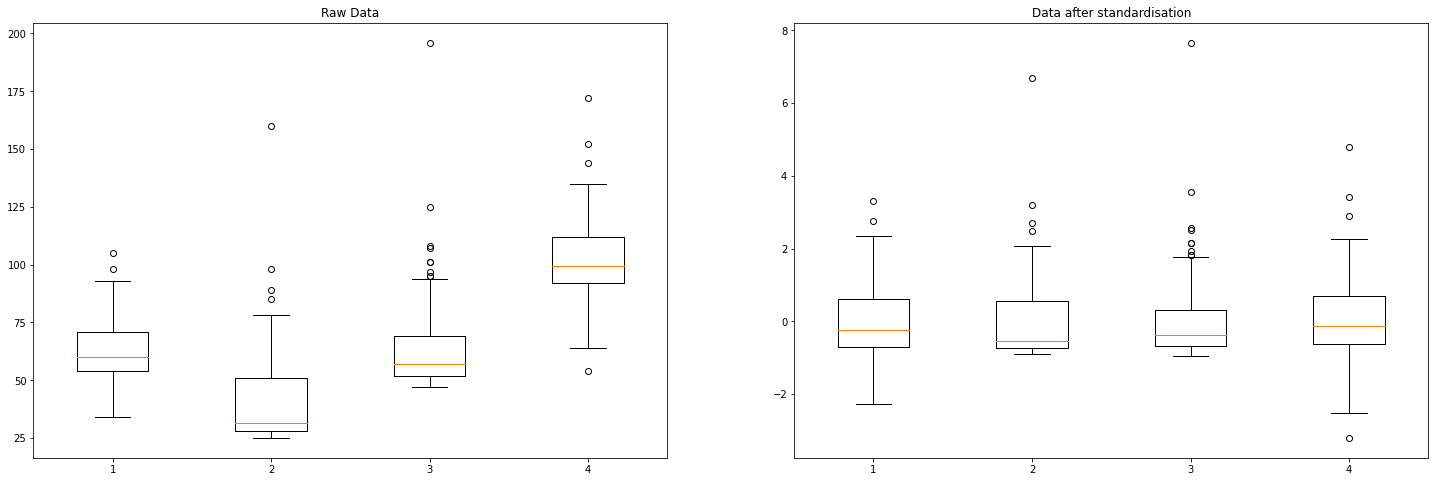

In [20]:
# get the data, we'll just grab 2 dimensions
X = train.iloc[:, 1:5].to_numpy()
train.iloc[:, 0] = train.iloc[:, 0].astype("category")
Y = train.iloc[:, 0].cat.codes.to_numpy()

# plot box plot for the data
fig = plt.figure(figsize=[25, 8])
ax = fig.add_subplot(1, 2, 1)
ax.boxplot(X)
ax.set_title('Raw Data')

# standardise data
mu = numpy.mean(X, 0)
sigma = numpy.std(X, 0)
X = (X - mu) / sigma

# box plot after standardisation
ax = fig.add_subplot(1, 2, 2)
ax.boxplot(X)
ax.set_title('Data after standardisation');

X_train = X
Y_train = Y

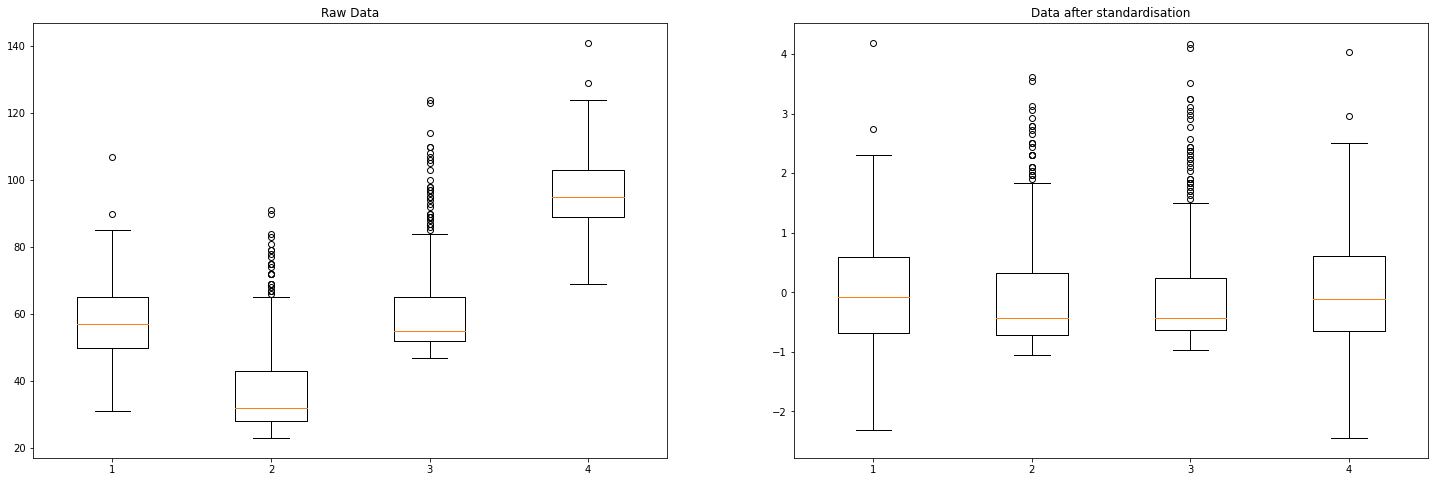

In [21]:
# get the data, we'll just grab 2 dimensions
X = test.iloc[:, 1:5].to_numpy()
test.iloc[:, 0] = test.iloc[:, 0].astype("category")
Y = test.iloc[:, 0].cat.codes.to_numpy()

# plot box plot for the data
fig = plt.figure(figsize=[25, 8])
ax = fig.add_subplot(1, 2, 1)
ax.boxplot(X)
ax.set_title('Raw Data')

# standardise data
mu = numpy.mean(X, 0)
sigma = numpy.std(X, 0)
X = (X - mu) / sigma

# box plot after standardisation
ax = fig.add_subplot(1, 2, 2)
ax.boxplot(X)
ax.set_title('Data after standardisation');

In [22]:
X_test, X_val, Y_test, Y_val = train_test_split(X, Y, test_size=0.5, random_state=1)

In [23]:
X_train.shape

(198, 4)

In [24]:
X_test.shape

(162, 4)

In [25]:
# function to do our eval for us, this is quite simple and will
# - create a figure
# - draw a confusion matrix for the trainign data in a sub-fig on the left
# - draw a confusion matrix for the testing data in a sub-fig on the right
# - compute the overall classification accuracy on the testing data
# this has simply been created as we're going to do this for each test that we run
def eval_model(model, X_train, Y_train, X_test, Y_test):
    fig = plt.figure(figsize=[25, 8])
    ax = fig.add_subplot(1, 2, 1)
    conf = plot_confusion_matrix(model, X_train, Y_train, normalize=None, xticks_rotation='vertical', ax=ax)
    pred = model.predict(X_train)
    conf.ax_.set_title('Training Set Performance: ' + str(sum(pred == Y_train)/len(Y_train)));
    ax = fig.add_subplot(1, 2, 2)
    conf = plot_confusion_matrix(model, X_test, Y_test, normalize=None, xticks_rotation='vertical', ax=ax)
    pred = model.predict(X_test)
    conf.ax_.set_title('Testing Set Performance: ' + str(sum(pred == Y_test)/len(Y_test)));

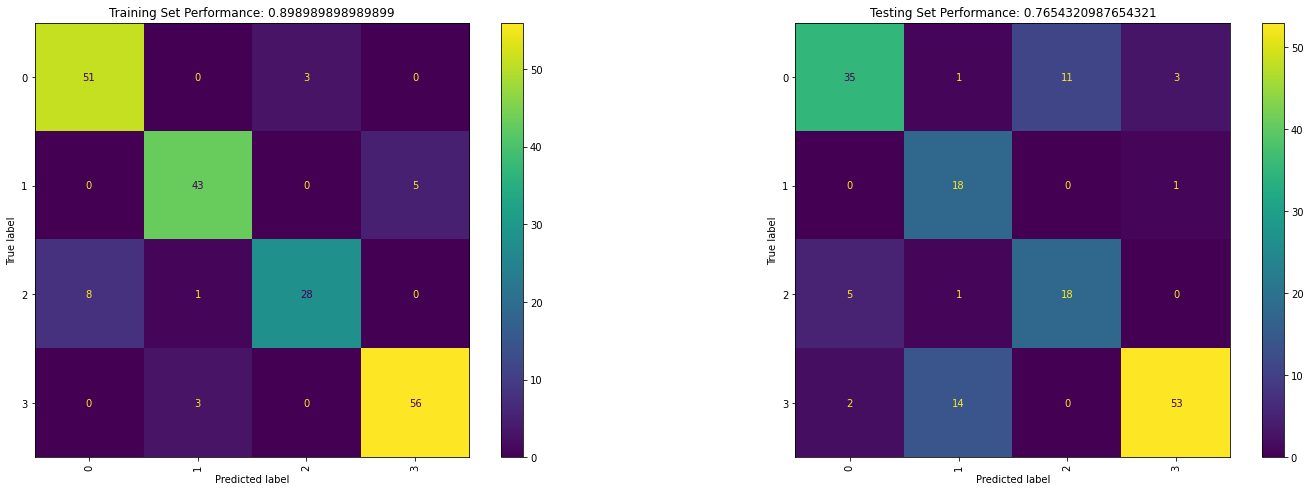

In [26]:
svm = SVC()
svm.fit(X_train, Y_train)
eval_model(svm, X_train, Y_train, X_test, Y_test)

In [27]:
param_grid = [
  {'C': [0.1, 1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [0.1, 1, 10, 100, 1000], 'gamma': [0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']},
  {'C': [0.1, 1, 10, 100, 1000], 'degree': [3, 4, 5, 6], 'kernel': ['poly']},
 ]
svm = SVC()
grid_search = GridSearchCV(svm, param_grid)
grid_search.fit(X_val, Y_val)
grid_search.cv_results_

{'mean_fit_time': array([0.00109134, 0.00069475, 0.00089293, 0.00347209, 0.02053671,
        0.00098329, 0.0011806 , 0.00108027, 0.0009932 , 0.00069056,
        0.00088949, 0.00099025, 0.00099154, 0.00079989, 0.00078716,
        0.001091  , 0.00098648, 0.00108562, 0.00109334, 0.00079341,
        0.00099192, 0.00207858, 0.00149317, 0.00079384, 0.0007935 ,
        0.00098958, 0.00099201, 0.00099192, 0.0008873 , 0.00109162,
        0.00139308, 0.00130281, 0.00157027, 0.00189023, 0.00228057,
        0.00246844, 0.00316849, 0.00585461, 0.00585279, 0.0064477 ,
        0.00763793, 0.06318998, 0.0305532 , 0.04652185, 0.03045363]),
 'std_fit_time': array([1.99031887e-04, 2.43237761e-04, 1.98626540e-04, 7.01458465e-04,
        5.46548917e-03, 1.18178681e-05, 2.45007702e-04, 2.04400629e-04,
        1.62917889e-05, 2.46584736e-04, 1.93003361e-04, 1.04203921e-05,
        2.40979743e-06, 2.48140990e-04, 2.39748185e-04, 1.98126212e-04,
        1.04519834e-05, 1.88064998e-04, 1.87071877e-04, 2.4339416

{'C': 10, 'kernel': 'linear'}


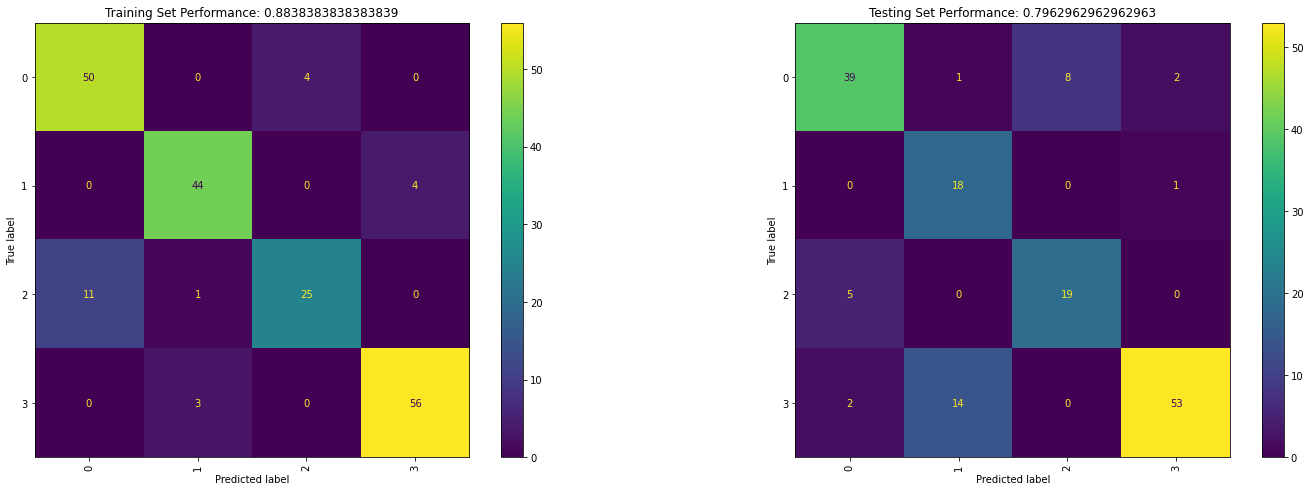

In [28]:
best_system = numpy.argmin(grid_search.cv_results_['rank_test_score'])
params = grid_search.cv_results_['params'][best_system]
print(params)
svm = SVC().set_params(**params)
svm.fit(X_train, Y_train)
eval_model(svm, X_train, Y_train, X_test, Y_test)

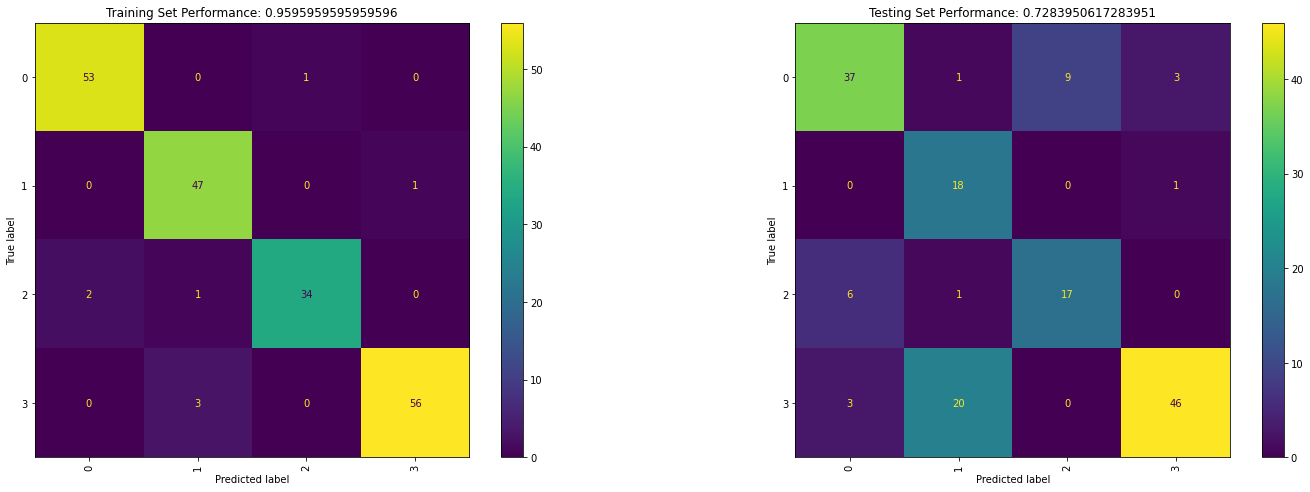

In [29]:
nu_svm = NuSVC(nu=0.15)
nu_svm.fit(X_train, Y_train)
eval_model(nu_svm, X_train, Y_train, X_test, Y_test)

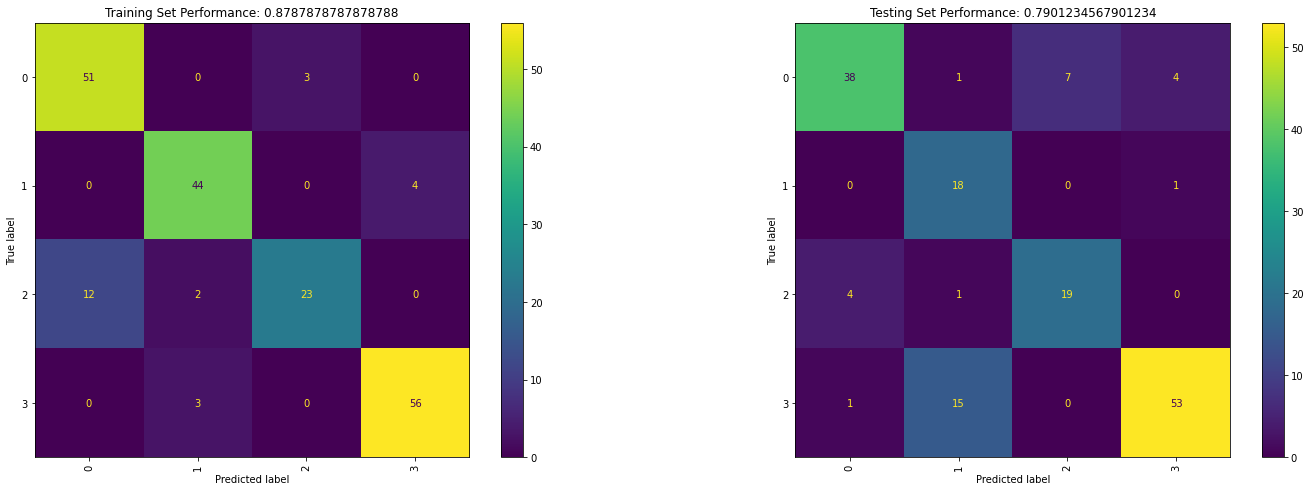

In [30]:
cknn = KNeighborsClassifier(n_neighbors=10)
cknn.fit(X_train, Y_train)
eval_model(cknn, X_train, Y_train, X_test, Y_test)

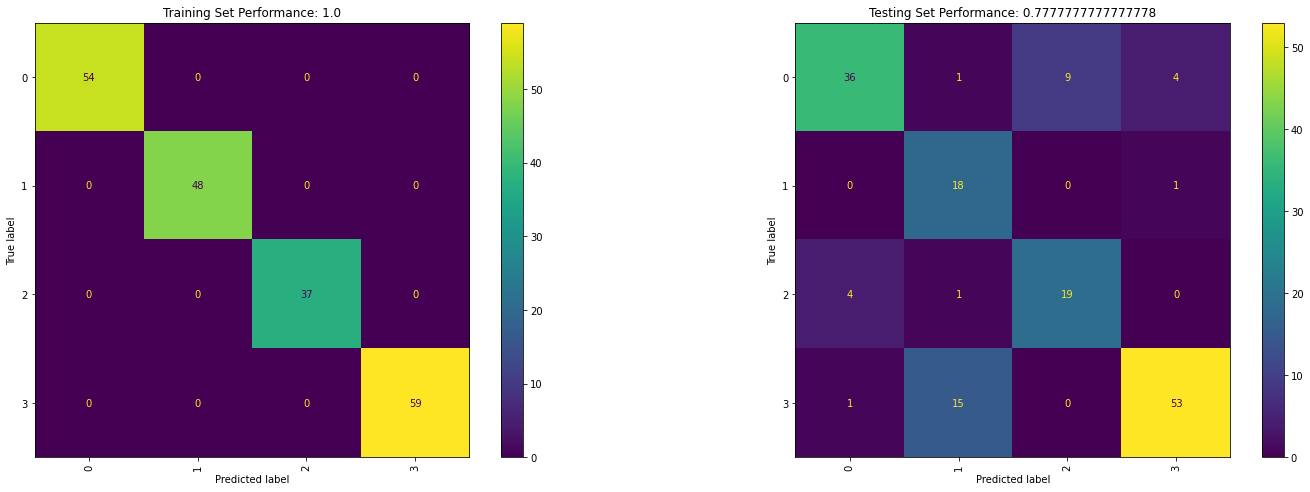

In [31]:
cknn = KNeighborsClassifier(n_neighbors=10, weights='distance')
cknn.fit(X_train, Y_train)
eval_model(cknn, X_train, Y_train, X_test, Y_test)

In [40]:
cknn = KNeighborsClassifier()
params = {'n_neighbors' : list(range(1,21)), 'weights' : ['uniform', 'distance']}
rand_search = RandomizedSearchCV(cknn, params, n_iter=20)
rand_search.fit(X_val, Y_val)
print(rand_search.cv_results_)

{'mean_fit_time': array([0.00039678, 0.00039325, 0.00038724, 0.00050879, 0.00029783,
       0.00040059, 0.00039763, 0.00029879, 0.00059366, 0.00049224,
       0.00039783, 0.00060234, 0.00049591, 0.00049582, 0.00029297,
       0.00039682, 0.00039701, 0.0002974 , 0.00039258, 0.00039697]), 'std_fit_time': array([1.98388522e-04, 1.96665623e-04, 1.94502011e-04, 1.63361098e-05,
       2.43181500e-04, 2.01283713e-04, 1.98825509e-04, 2.43959061e-04,
       1.84178129e-04, 2.04665930e-05, 1.98915785e-04, 1.97618578e-04,
       4.26496120e-07, 3.87384339e-07, 2.39377734e-04, 1.98412027e-04,
       1.98507681e-04, 2.42828947e-04, 1.96534241e-04, 1.98483775e-04]), 'mean_score_time': array([0.00059371, 0.00089731, 0.00068932, 0.00068769, 0.0007987 ,
       0.00088787, 0.00059423, 0.00148816, 0.00089369, 0.00149102,
       0.00158138, 0.0012825 , 0.00059361, 0.00148802, 0.0015975 ,
       0.00119038, 0.0006001 , 0.00070491, 0.00070047, 0.000595  ]), 'std_score_time': array([1.94883667e-04, 1.8911367

{'weights': 'distance', 'n_neighbors': 3}


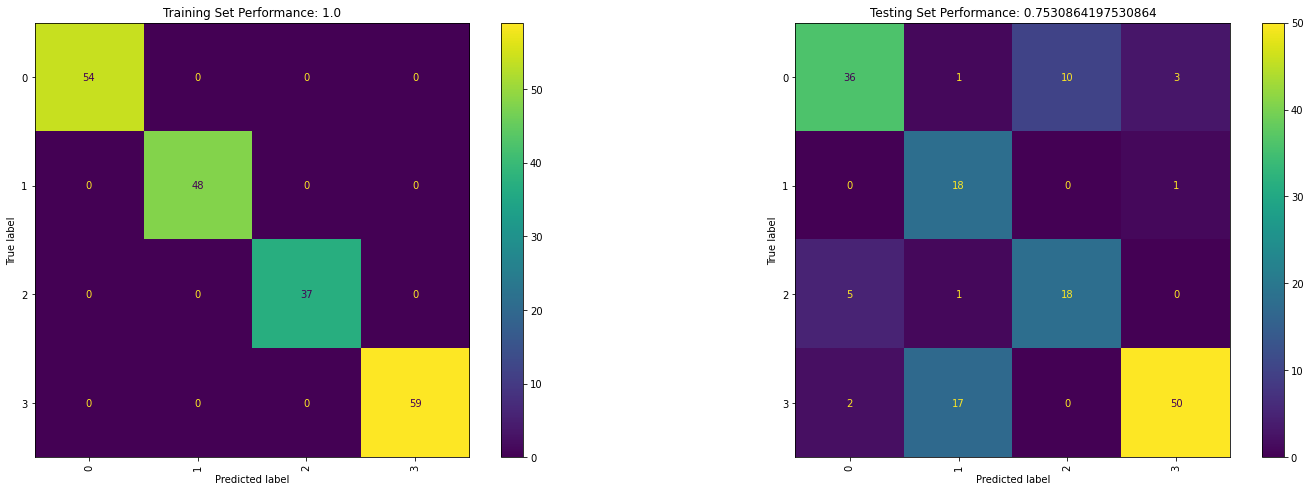

In [41]:
best_system = numpy.argmin(rand_search.cv_results_['rank_test_score'])
params = rand_search.cv_results_['params'][best_system]
print(params)
cknn = KNeighborsClassifier().set_params(**params)
cknn.fit(X_train, Y_train)
eval_model(cknn, X_train, Y_train, X_test, Y_test)

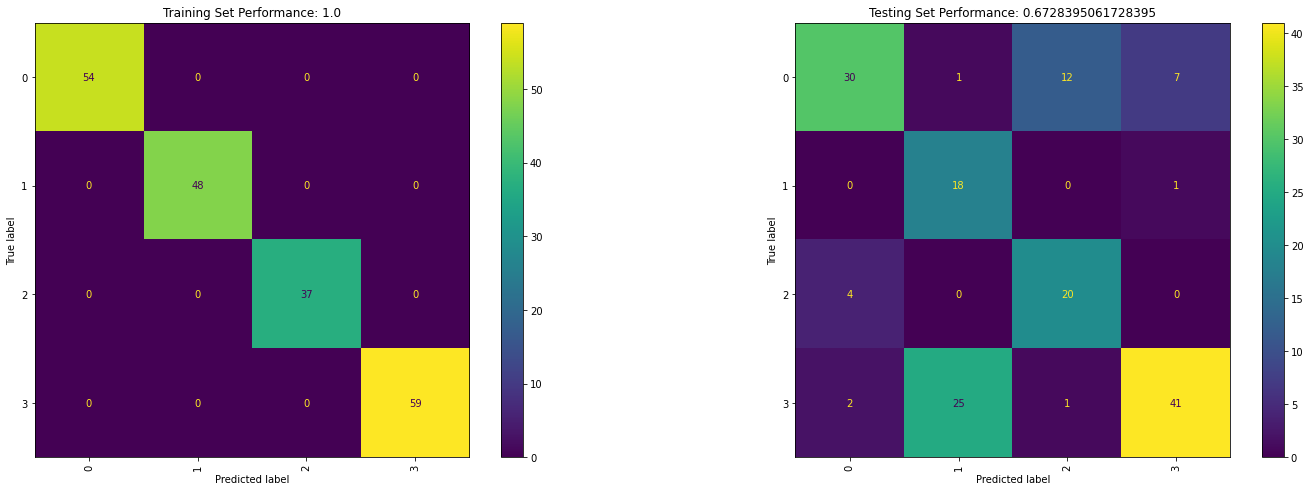

In [32]:
rf = RandomForestClassifier(n_estimators=250, max_depth=15, random_state=0)
rf.fit(X_train, Y_train)
eval_model(rf, X_train, Y_train, X_test, Y_test)

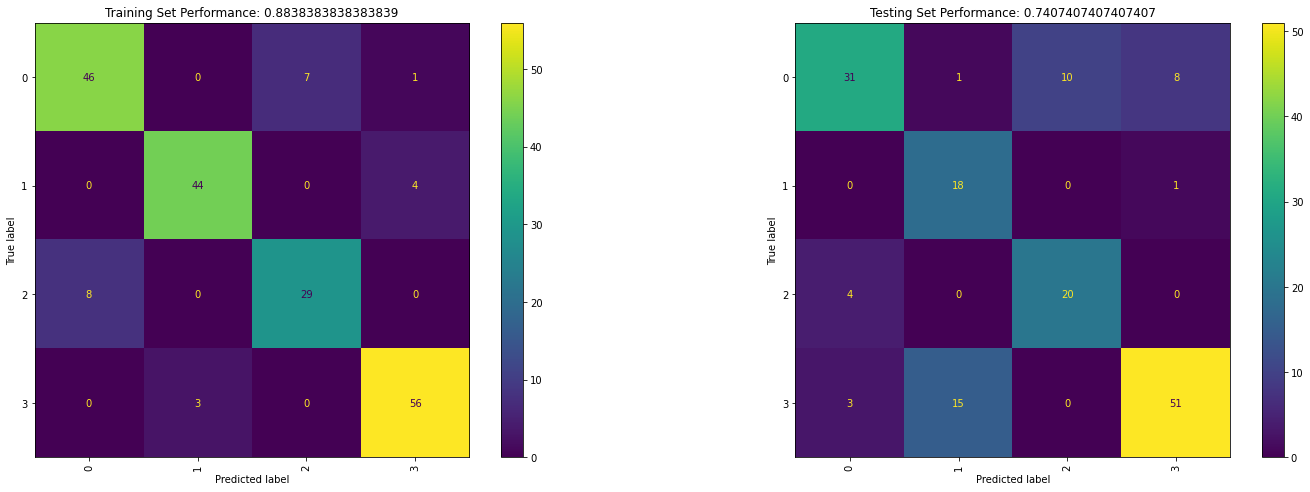

In [33]:
rf = RandomForestClassifier(n_estimators=250, max_depth=2, random_state=0, class_weight='balanced_subsample')
rf.fit(X_train, Y_train)
eval_model(rf, X_train, Y_train, X_test, Y_test)

30
24
27


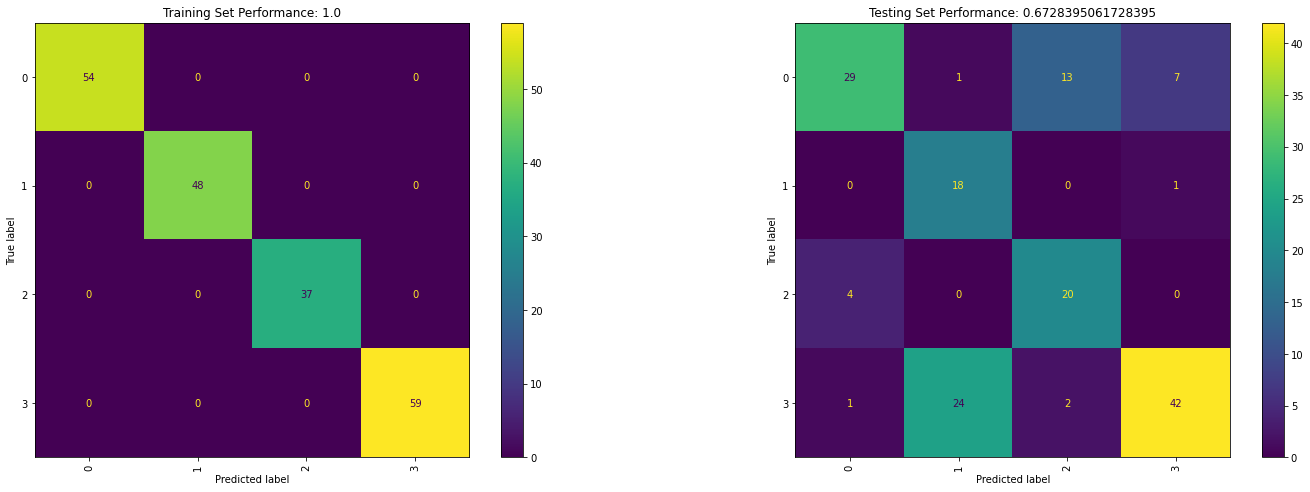

In [34]:
rf = RandomForestClassifier(n_estimators=250, max_depth=15, random_state=0, class_weight='balanced_subsample')
rf.fit(X_train, Y_train)
eval_model(rf, X_train, Y_train, X_test, Y_test)
print(rf.estimators_[0].tree_.n_leaves)
print(rf.estimators_[4].tree_.n_leaves)
print(rf.estimators_[42].tree_.n_leaves)

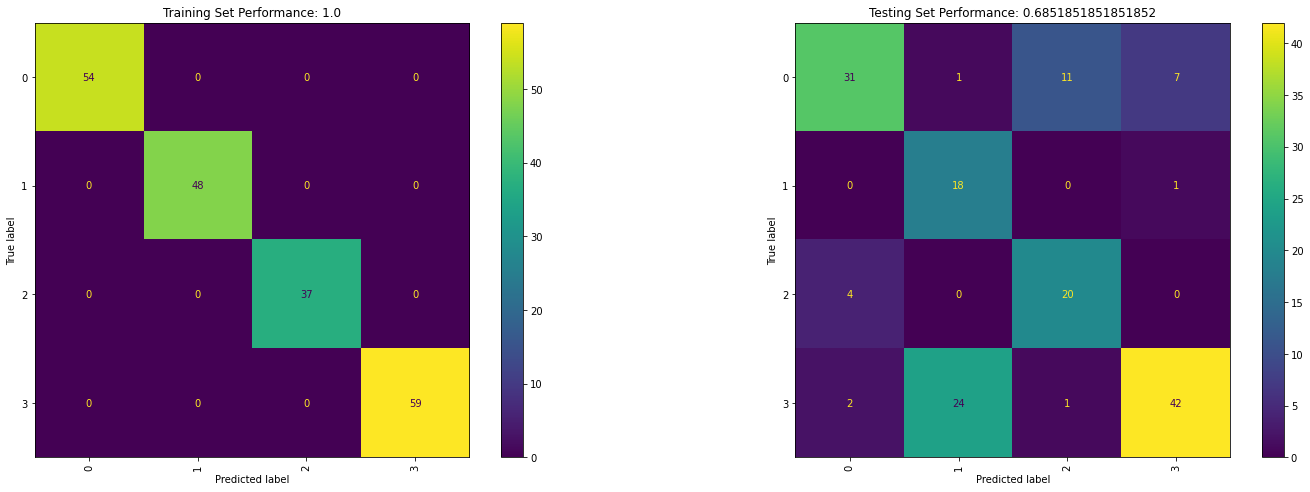

In [35]:
rf = RandomForestClassifier(n_estimators=250, max_depth=15, random_state=0, class_weight='balanced')
rf.fit(X_train, Y_train)
eval_model(rf, X_train, Y_train, X_test, Y_test)